In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import CategoricalEncoder
from __future__ import division   #this is so 2/5 returns 0.4 not 0

Our dataset appears to consist of two types of samples - bid samples, and ad samples. Since we are only trying to predict clicks on the ad, AKA "c_cnt", which only exists in ad samples, we will only be working with those data. Let's first parse the data and get what we need.

In [2]:
#reads a weird json, and returns the bids dataframe and ads dataframe
def read_weird_json(path):
    bids = []
    ads = []

    with open(path) as f:
        for line in f:
            line_dict = json.loads(line)
            if 'advertiser_id' in line_dict:
                if line_dict['rate_metric'] != 'CPC':
                    continue
                ads.append(line_dict)
            else:
                bids.append(line_dict)

    df_bids = pd.DataFrame.from_records(bids)
    df_ads = pd.DataFrame.from_records(ads)  
    
    return [df_bids, df_ads]

#Returns a list of dataframes. Only looks at ads. 
def read_many_jsons(paths): 
    dfs = []
    for path in paths: 
        dfs += [read_weird_json(path)[1]]
    return dfs
    
dfs = read_many_jsons(['./data/combined.11.12', './data/combined.11.13', './data/combined.11.14', './data/combined.11.19'])

In [84]:
#Create one dataframe with the combined data. 
df = pd.concat(dfs)

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than 20,000 non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [85]:
#how many non-nan values do we have?
print(df.count())

#filter threshhold
df = df.dropna(thresh=20000, axis=1)
#filter rows with c_cnt as NaN
df = df[np.isfinite(df['c_cnt'])]
#drop all samples with NaN values
df = df.dropna(axis=0)

ad_network_id            861464
ad_type                  861464
advertiser_id            861464
bid_requests             861464
bid_responses            861464
c_cnt                    686533
c_timestamp                 457
c_txn_fee                   457
c_txn_rate                  457
campaign_id              861464
campaign_type            861464
cr_cnt                   861464
creative_id              861464
exp_mode                 180500
f_cnt                    686533
geo_continent_code       861443
geo_country_code2        861443
geo_dma_code             861443
geo_region_name          837769
geo_timezone             848547
i_cnt                    686533
i_timestamp              686247
pub_network_id           861464
r_cnt                    861464
r_num_ads_requested      861464
r_num_ads_returned       861464
r_num_ads_third_party    861464
r_timestamp              861464
rate_metric              861464
session_id               861464
site_id                  861464
token   

#### Choosing the features/columns I want to keep (not sure how jank this is)

In [86]:
df = df[['ad_network_id', 'ua_device_type', 'ua_device', 'vi_cnt', 'i_cnt', 'c_cnt', 'ad_type', 'advertiser_id', 'pub_network_id', 'site_id']]

In [87]:
df.shape

(24309, 10)

Creates another temporary table with the manually created features (ie. c_cnt/vi_cnt, which we found was useful for classifying publishers). We still keep advertiser_id and device_type because this is how they're categorized.

In [88]:
result = df.copy()
result = result[['c_cnt', 'vi_cnt', 'i_cnt', 'advertiser_id', 'pub_network_id', 'site_id', 'ua_device_type']]
collective = result.groupby(['advertiser_id', 'ua_device_type'])['c_cnt', 'vi_cnt', 'i_cnt'].sum()
advertisers_c_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['c_cnt'].sum()
advertisers_vi_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['vi_cnt'].sum()
advertisers_i_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['i_cnt'].sum()

collective['total_count'] = result.groupby(['advertiser_id', 'ua_device_type']).count()['site_id']
collective['c_cnt/v_cnt'] = advertisers_c_cnt/advertisers_vi_cnt
collective['vi_cnt/i_cnt'] = advertisers_vi_cnt/advertisers_i_cnt
collective['c_cnt/i_cnt'] = advertisers_c_cnt/advertisers_i_cnt
collective.drop(['c_cnt', 'vi_cnt', 'i_cnt', 'total_count'], axis=1, inplace=True)
collective.reset_index(inplace=True)

collective.fillna(value=0, inplace=True)

collective

,advertiser_id,ua_device_type,c_cnt/v_cnt,vi_cnt/i_cnt,c_cnt/i_cnt
0,5063,BOT,0.000000,0.0,0.000000
1,5063,MOB,0.006876,1.0,0.006876
2,5063,PC,0.006549,1.0,0.006549
3,5063,TAB,0.010288,1.0,0.010288
4,5152,MOB,0.010492,1.0,0.010492
5,5152,PC,0.008367,1.0,0.008367
6,5152,TAB,0.012965,1.0,0.012965
7,5189,MOB,0.013333,1.0,0.013333
8,5189,PC,0.004484,1.0,0.004484
9,5189,TAB,0.025907,1.0,0.025907


In [89]:
df.head()

,ad_network_id,ua_device_type,ua_device,vi_cnt,i_cnt,c_cnt,ad_type,advertiser_id,pub_network_id,site_id
15,727,MOB,Samsung SM-N950F,1.0,1.0,0.0,[story],5152,727,10481
40,727,TAB,iPad,1.0,1.0,0.0,[story],5063,727,10481
109,727,TAB,iPad,1.0,1.0,0.0,[story],5189,727,10481
207,727,MOB,iPhone,1.0,1.0,0.0,[story],5063,727,10481
261,727,MOB,ONEPLUS A3010,1.0,1.0,0.0,[story],5152,727,10481


Merges the original table with the new table of created features

In [90]:
df = pd.merge(df, collective, on=['advertiser_id', 'ua_device_type'])
df = df[df.ua_device_type != 'BOT']
df.head()

,ad_network_id,ua_device_type,ua_device,vi_cnt,i_cnt,c_cnt,ad_type,advertiser_id,pub_network_id,site_id,c_cnt/v_cnt,vi_cnt/i_cnt,c_cnt/i_cnt
0,727,MOB,Samsung SM-N950F,1.0,1.0,0.0,[story],5152,727,10481,0.010492,1.0,0.010492
1,727,MOB,ONEPLUS A3010,1.0,1.0,0.0,[story],5152,727,10481,0.010492,1.0,0.010492
2,727,MOB,Samsung SM-G920I,1.0,1.0,0.0,[story],5152,727,10481,0.010492,1.0,0.010492
3,727,MOB,iPhone,1.0,1.0,0.0,[story],5152,727,10481,0.010492,1.0,0.010492
4,727,MOB,ONEPLUS A5010,1.0,1.0,0.0,[story],5152,727,10481,0.010492,1.0,0.010492


Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [91]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
#     df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_min)
#     df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_min)
    
#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200, return_labels=False):
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
#     print col
#     print 'BOT' in df_frequency.columns
#     if 'BOT' in df_frequency.columns: 
#         df_frequency.drop('BOT', inplace=True, axis=1)
#     print(df_frequency)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

#final preprocessing
preprocess(df)
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt','total_count','c_cnt/v_cnt','vi_cnt/i_cnt','c_cnt/i_cnt'])
#we create a copy so that X will not include 'c_cnt'
df2 = df.copy()
df2.drop('c_cnt',inplace=True,axis=1)
#u,s,v = np.linalg.svd(X)

Prints out all features after performing one hot encoding with the given threshold. 

In [92]:
one_hot_thresh = 5
Y = df['c_cnt'].values
labels = np.hstack([transform_column(df, col, thresh=one_hot_thresh, return_labels=True) if col not in numerical_features else [str(col)] for col in df2])
X = np.hstack([transform_column(df, col, thresh=one_hot_thresh) if col not in numerical_features else df[col].values.reshape(-1,1)
               for col in df2])

In [93]:
print(X.shape)
print(Y.shape)

(24308, 13)
(24308,)


In [94]:
#Do cross validation
ind_cutoff = int(0.7*len(X))
X_train, Y_train = X[0:ind_cutoff], Y[0:ind_cutoff]
X_test, Y_test = X[ind_cutoff:], Y[ind_cutoff:]

In [95]:
print(X_train.shape) 
print(X_test.shape)

(17015, 13)
(7293, 13)


We want to make sure the data we have is representative of data in the real world, so we need to split the data and make sure the click ratio is equal to 0.9.

In [96]:
def fix_class_imbalance_with_subsampling(X, Y, pos_ratio=9):
    Y = Y.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(Y):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([X[ind_1],X[to_sample_0]])
    Y2 = np.vstack([Y[ind_1],Y[to_sample_0]])
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]
X_train, Y_train = fix_class_imbalance_with_subsampling(X_train,Y_train)
Y_train = np.ravel(Y_train)
print(X_train.shape)
print(Y_train.shape)

(1590, 13)
(1590,)


In [97]:
print("Training data stats: ") 
print("Number of nonzero c_cnts: ", np.count_nonzero(Y_train))
print("Ratio of nonzero c_cnts: ", np.count_nonzero(Y_train)/ len(Y_train))

print("Testing data stats:")
print("Number of nonzero c_cnts: ", np.count_nonzero(Y_test))
print("Ratio of nonzero c_cnts: ", np.count_nonzero(Y_test)/ len(Y_test))

Training data stats: 
('Number of nonzero c_cnts: ', 159)
('Ratio of nonzero c_cnts: ', 0.1)
Testing data stats:
('Number of nonzero c_cnts: ', 66)
('Ratio of nonzero c_cnts: ', 0.00904977375565611)


Now let's try to fit our data to a logistic regression model. We're going to print the weight for each feature. 

In [98]:
logreg = LogisticRegression(C=0.1)
logreg.fit(X_train, Y_train)
for i in range(len(labels)):
    print labels[i],": ", logreg.coef_[0][i]
print(X_train[0])
print(X_test[0])

ua_device_typeMOB :  -1.26623674741
ua_device_typePC :  1.04572511237
ua_device_typeTAB :  0.347876089324
ua_deviceOther :  -0.113061408404
ua_deviceiPhone :  1.04572511237
ua_deviceiPad :  0.0216527142146
ua_devicePixel 2 :  0.157345914707
ua_deviceGeneric Smartphone :  -0.0545406995671
advertiser_id5152 :  1.40925633796
advertiser_id5063 :  -1.4506237317
advertiser_id5189 :  0.168731848029
c_cnt/v_cnt :  -0.00276970708948
c_cnt/i_cnt :  -0.00276970708948
[ 1.          0.          0.          0.          0.          0.          0.
  1.          0.          1.          0.          0.01049233  0.01049233]
[ 0.          1.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.00836735  0.00836735]


In [99]:
print("Training accuracy", 100*logreg.score(X_train,Y_train), "%")
print("Validation accuracy", 100*logreg.score(X_test,Y_test), "%")

train_prediction = logreg.predict(X_train)
test_prediction = logreg.predict(X_test)

train_confusion_matrix = confusion_matrix(Y_train, train_prediction)
test_confusion_matrix = confusion_matrix(Y_test, test_prediction)

# #What percent of the positive cases did we catch? 
print("Training Recall:", train_confusion_matrix[1][1]/sum(train_confusion_matrix[1]))
print("Validation Recall:", test_confusion_matrix[1][1]/sum(test_confusion_matrix[1]))

# #What percent of the positive predictions was correct?

print("Training Precision:", train_confusion_matrix[1][1]/(train_confusion_matrix[1][1] + train_confusion_matrix[0][1]))
print("Validation Precision:", test_confusion_matrix[1][1]/(test_confusion_matrix[1][1] + test_confusion_matrix[0][1]))

print("Confusion Matrix for Training Data")
print(train_confusion_matrix)

print("Confusion Matrix for Testing Data")
# #TN FP 
# #FN TP 
print(test_confusion_matrix)

('Training accuracy', 95.094339622641513, '%')
('Validation accuracy', 39.846428081722202, '%')
('Training Recall:', 0.50943396226415094)
('Validation Recall:', 0.42424242424242425)
('Training Precision:', 1.0)
('Validation Precision:', 0.0063970756225725381)
Confusion Matrix for Training Data
[[1431    0]
 [  78   81]]
Confusion Matrix for Testing Data
[[2878 4349]
 [  38   28]]


In [100]:
print("Probabilities for Training Data")

predictions_train = pd.DataFrame(logreg.predict_proba(X_train), columns=['Probability of No Click', 'Probability of Click'])
predictions_train['Prediction'] = logreg.predict(X_train)
predictions_train['Actual'] = Y_train
predictions_train['Correct'] = (predictions_train['Prediction'] == predictions_train['Actual'])

predictions_train

Probabilities for Training Data


,Probability of No Click,Probability of Click,Prediction,Actual,Correct
0,0.933646,0.066354,0.0,0.0,True
1,0.933646,0.066354,0.0,0.0,True
2,0.937181,0.062819,0.0,0.0,True
3,0.930186,0.069814,0.0,0.0,True
4,0.930186,0.069814,0.0,0.0,True
5,0.930186,0.069814,0.0,0.0,True
6,0.930186,0.069814,0.0,1.0,False
7,0.930186,0.069814,0.0,0.0,True
8,0.933646,0.066354,0.0,0.0,True
9,0.930186,0.069814,0.0,0.0,True


In [101]:
print("Probabilities for Testing Data")

predictions_test = pd.DataFrame(logreg.predict_proba(X_test), columns=['Probability of No Click', 'Probability of Click'])
predictions_test['Prediction'] = logreg.predict(X_test)
predictions_test['Actual'] = Y_test
predictions_test['Correct'] = (predictions_test['Prediction'] == predictions_test['Actual'])

predictions_test

Probabilities for Testing Data


,Probability of No Click,Probability of Click,Prediction,Actual,Correct
0,0.316881,0.683119,1.0,0.0,False
1,0.316881,0.683119,1.0,0.0,False
2,0.316881,0.683119,1.0,0.0,False
3,0.316881,0.683119,1.0,0.0,False
4,0.316881,0.683119,1.0,0.0,False
5,0.316881,0.683119,1.0,0.0,False
6,0.316881,0.683119,1.0,0.0,False
7,0.316881,0.683119,1.0,0.0,False
8,0.316881,0.683119,1.0,0.0,False
9,0.316881,0.683119,1.0,0.0,False


Here, we're testing different parameters for the number of features we want to keep, iterating from start to end with step size. We are finding features using sklearn.SelectKBest with a chi2 test to select the features for us.

In [111]:
def find_optimal_num_features(X,Y,start,end,step): 
    
    rows_training = []
    rows_testing = []
    for i in range(start,end,step): 
        test = SelectKBest(chi2, k=i)
        X_new = test.fit_transform(X, Y)
        print i, " ", labels[test.get_support()]
                  
        ind_cutoff = int(0.7*len(X_new))
        X_train, Y_train = X_new[0:ind_cutoff], Y[0:ind_cutoff]
        X_test, Y_test = X_new[ind_cutoff:], Y[ind_cutoff:]
        
        X_train, Y_train = fix_class_imbalance_with_subsampling(X_train,Y_train)
        Y_train = np.ravel(Y_train)
        
        logreg = LogisticRegression(C=1)
        logreg.fit(X_train, Y_train)
    
        train_prediction = logreg.predict(X_train)
        test_prediction = logreg.predict(X_test)

        train_confusion_matrix = confusion_matrix(Y_train, train_prediction)
        test_confusion_matrix = confusion_matrix(Y_test, test_prediction)
    
        precision_training = train_confusion_matrix[1][1]/(train_confusion_matrix[1][1] + train_confusion_matrix[0][1])
        precision_testing = test_confusion_matrix[1][1]/(test_confusion_matrix[1][1] + test_confusion_matrix[0][1])
        
        recall_training = train_confusion_matrix[1][1]/sum(train_confusion_matrix[1])
        recall_testing = test_confusion_matrix[1][1]/sum(test_confusion_matrix[1])
        
        rows_training += [[i, 100*logreg.score(X_train,Y_train), train_confusion_matrix[0][0], 
             train_confusion_matrix[0][1], train_confusion_matrix[1][0], train_confusion_matrix[1][1], precision_training, 
                          recall_training]]
        rows_testing += [[i, 100*logreg.score(X_test,Y_test), test_confusion_matrix[0][0], 
             test_confusion_matrix[0][1], test_confusion_matrix[1][0], test_confusion_matrix[1][1], precision_testing, 
                         recall_testing]]
    return rows_training, rows_testing

rows_training, rows_testing = find_optimal_num_features(X,Y,1,14,1)

1   ['ua_device_typeTAB']
2   ['ua_device_typeTAB' 'ua_deviceiPhone']
3   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone']
4   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone'
 'advertiser_id5152']
5   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone'
 'advertiser_id5152' 'advertiser_id5063']
6   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone'
 'ua_devicePixel 2' 'advertiser_id5152' 'advertiser_id5063']
7   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone'
 'ua_devicePixel 2' 'ua_deviceGeneric Smartphone' 'advertiser_id5152'
 'advertiser_id5063']
8   ['ua_device_typePC' 'ua_device_typeTAB' 'ua_deviceiPhone'
 'ua_devicePixel 2' 'ua_deviceGeneric Smartphone' 'advertiser_id5152'
 'advertiser_id5063' 'advertiser_id5189']
9   ['ua_device_typeMOB' 'ua_device_typePC' 'ua_device_typeTAB'
 'ua_deviceiPhone' 'ua_devicePixel 2' 'ua_deviceGeneric Smartphone'
 'advertiser_id5152' 'advertiser_id5063' 'advertiser_id5189']
10   ['ua_device_typeMOB' 'ua_devi

In [112]:
print("Results for Training Data")
df_training = pd.DataFrame(rows_training, columns=['num_features', 'accuracy', 'TN', 'FP', 
                           'FN', 'TP', "Precision", "Recall"])
df_training.set_index("num_features", inplace=True)
df_training

Results for Training Data


,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
1,91.257862,1431,0,139,20,1.0,0.125786
2,93.333333,1431,0,106,53,1.0,0.333333
3,93.333333,1431,0,106,53,1.0,0.333333
4,94.779874,1431,0,83,76,1.0,0.477987
5,95.094340,1431,0,78,81,1.0,0.509434
6,95.094340,1431,0,78,81,1.0,0.509434
7,95.094340,1431,0,78,81,1.0,0.509434
8,95.094340,1431,0,78,81,1.0,0.509434
9,95.094340,1431,0,78,81,1.0,0.509434


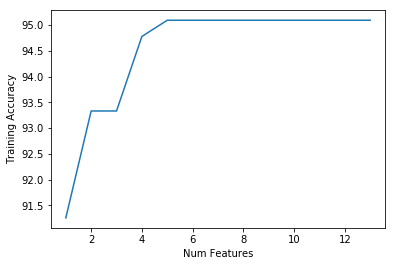

In [113]:
plt.plot(df_training.index.values, df_training['accuracy'])
plt.xlabel("Num Features")
plt.ylabel("Training Accuracy")
plt.show()

In [114]:
print("Results for Testing Data")
df_testing= pd.DataFrame(rows_testing, columns=['num_features', 'accuracy', 'TN', 'FP', 
                           'FN', 'TP', "Precision", "Recall"])

df_testing.set_index("num_features", inplace=True)
df_testing

Results for Testing Data


,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
1,67.160291,4867,2360,35,31,0.012965,0.469697
2,7.911696,518,6709,7,59,0.008717,0.893939
3,7.911696,518,6709,7,59,0.008717,0.893939
4,39.846428,2878,4349,38,28,0.006397,0.424242
5,32.839709,2360,4867,31,35,0.007140,0.530303
6,32.839709,2360,4867,31,35,0.007140,0.530303
7,32.839709,2360,4867,31,35,0.007140,0.530303
8,32.839709,2360,4867,31,35,0.007140,0.530303
9,39.846428,2878,4349,38,28,0.006397,0.424242


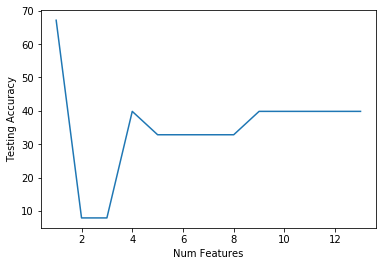

In [115]:
plt.plot(df_testing.index.values, df_testing['accuracy'])
plt.xlabel("Num Features")
plt.ylabel("Testing Accuracy")
plt.show()

In [116]:
testing_sorted = df_testing.sort_values(by="accuracy", ascending=False)
testing_sorted

,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
1,67.160291,4867,2360,35,31,0.012965,0.469697
4,39.846428,2878,4349,38,28,0.006397,0.424242
9,39.846428,2878,4349,38,28,0.006397,0.424242
10,39.846428,2878,4349,38,28,0.006397,0.424242
11,39.846428,2878,4349,38,28,0.006397,0.424242
12,39.846428,2878,4349,38,28,0.006397,0.424242
13,39.846428,2878,4349,38,28,0.006397,0.424242
5,32.839709,2360,4867,31,35,0.007140,0.530303
6,32.839709,2360,4867,31,35,0.007140,0.530303


Plots out the graphs for Recall vs Precision and True positive vs False positive

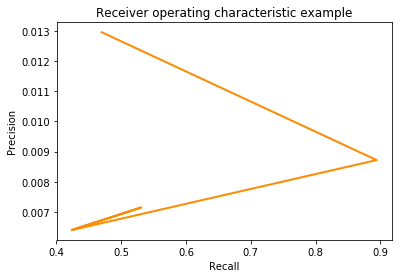

In [117]:
plt.figure()
lw = 2
plt.plot(df_testing.Recall.tolist(), df_testing.Precision.tolist(), color='darkorange',
         lw=lw)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver operating characteristic example')
plt.show()

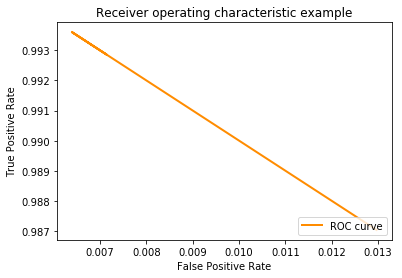

In [118]:
plt.figure()
lw = 2
total_positives = np.array(df_testing.TP.tolist(), dtype=np.float) + np.array(df_testing.FP.tolist(), dtype=np.float)
total = np.array(total_positives, dtype=np.float)
tp = np.array(df_testing.TP.tolist(), dtype=np.float)
fp = np.array(df_testing.FP.tolist(), dtype=np.float)

plt.plot(tp/total, fp/total, color='darkorange', lw=lw, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()